## Example for a CNN-LSTM model to predict BTC close price over next 15 min

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/sats4u/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import json
import sys
import pandas as pd
import numpy as np
import math
from datetime import datetime
import time
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
import src.loadcrypto as lc
import src.featbuild as fb
import src.candles2timeseries as c2t
import src.sats2model as s2m


# settings for reproducible results
#os.environ['CUDA_VISIBLE_DEVICES'] = ''
np.random.seed(420)
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(420)

## Load Asset Details, Binance client data and Download 15m candles from Binance

In [4]:
data_folder = "data/"
asset_details = pd.read_csv(data_folder + 'asset_details.csv')

In [5]:
secret_data_folder = '/content/drive/MyDrive/Colab Notebooks/crypto_project/crypto_data/'
secrets_filename = secret_data_folder+'data.json'

In [6]:
crypto = lc.CryptoData(asset_details,data_folder)
crypto.load_binance_client(secrets_filename,data1_str = 'DATA1',data2_str = 'DATA2i')
crypto.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')

In [7]:
tickers=crypto.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)

In [8]:
ldata_df = crypto.load_cryptos(tickers,save = False)                             

All caught up..!
size of dataset: (169599, 8)


In [9]:
ldata_df

,timestamp,OpenBitcoin,HighBitcoin,LowBitcoin,CloseBitcoin,VolumeBitcoin,CountBitcoin,Date,Future Date
timestamp,,,,,,,,,
1502942400,1502942400,4261.48,4280.56,4261.48,4261.48,2.189061,9.0,2017-08-17 04:01:00,2017-08-17 04:15:00
1502943300,1502943300,4261.48,4270.41,4261.32,4261.45,9.119865,40.0,2017-08-17 04:16:00,2017-08-17 04:30:00
1502944200,1502944200,4280.00,4310.07,4267.99,4310.07,21.923552,58.0,2017-08-17 04:31:00,2017-08-17 04:45:00
1502945100,1502945100,4310.07,4313.62,4291.37,4308.83,13.948531,64.0,2017-08-17 04:46:00,2017-08-17 05:00:00
1502946000,1502946000,4308.83,4328.69,4304.31,4304.31,5.101153,44.0,2017-08-17 05:01:00,2017-08-17 05:15:00
...,...,...,...,...,...,...,...,...,...
1656078300,1656078300,21271.04,21376.00,21190.81,21199.99,1127.709890,17869.0,2022-06-24 13:46:00,2022-06-24 14:00:00
1656079200,1656079200,21199.98,21339.95,21199.98,21326.10,960.753100,16994.0,2022-06-24 14:01:00,2022-06-24 14:15:00
1656080100,1656080100,21326.10,21374.99,21248.45,21250.98,705.837940,13585.0,2022-06-24 14:16:00,2022-06-24 14:30:00


### Plot wick Candles and build features from technical analysis

In [10]:
can_btc = fb.Candles(ldata_df,"Bitcoin")
can_btc.candles

,Low,High,Open,Close,Volume
Date,,,,,
2017-08-17 04:01:00,4261.48,4280.56,4261.48,4261.48,2.189061
2017-08-17 04:16:00,4261.32,4270.41,4261.48,4261.45,9.119865
2017-08-17 04:31:00,4267.99,4310.07,4280.00,4310.07,21.923552
2017-08-17 04:46:00,4291.37,4313.62,4310.07,4308.83,13.948531
2017-08-17 05:01:00,4304.31,4328.69,4308.83,4304.31,5.101153
...,...,...,...,...,...
2022-06-24 13:46:00,21190.81,21376.00,21271.04,21199.99,1127.709890
2022-06-24 14:01:00,21199.98,21339.95,21199.98,21326.10,960.753100
2022-06-24 14:16:00,21248.45,21374.99,21326.10,21250.98,705.837940


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

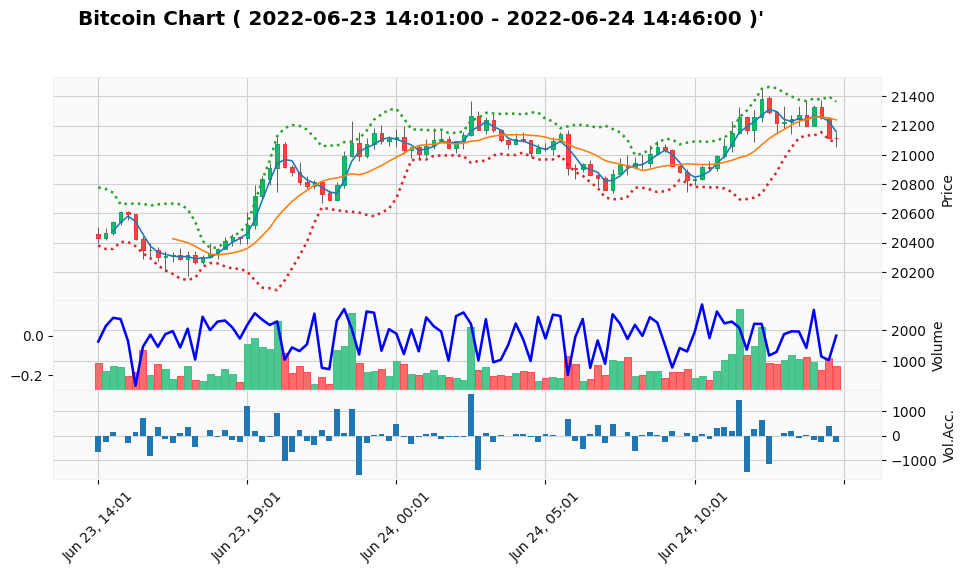

In [11]:
can_btc.buildfeatures()
can_btc.ta_fullplot()

# Generate normalized timeseries

In [12]:
ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 50000, step_back = 48, candle_step_str = "15m",
                lownorm = 0.2, upnorm= 0.8)

ts_btc.candles2ts()

Candles Normalized
Extracted last 50000 steps
Generated time-series
Normalized 'candles_norm' with shape : (50000, 9)
Feature data 'x_candles' with size : 49952
Feature data with time intervals 'x_time' with size : 49952


In [13]:
ts_btc.x_candles
ts_btc.x_time
ts_btc.y[-10:]

[0.3681757055125352,
 0.3674861037134156,
 0.36755393489117427,
 0.36778975066351643,
 0.36799415468239993,
 0.3673471636097113,
 0.368495377009328,
 0.3678114202209749,
 0.36655677105384166,
 0.36655403959701915]

## Train a CNN-LSTM model 

In [16]:
btc_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler, split_fraction = 0.9)

In [17]:
btc_model.sats2model()
btc_model.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 candles (InputLayer)           [(None, 48, 9)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 48, 32)       896         ['candles[0][0]']                
                                                                                                  
 conv1d_2 (Conv1D)              (None, 48, 32)       2048        ['candles[0][0]']                
                                                                                                  
 conv1d_4 (Conv1D)              (None, 48, 32)       3776        ['candles[0][0]']                
                                                                                              

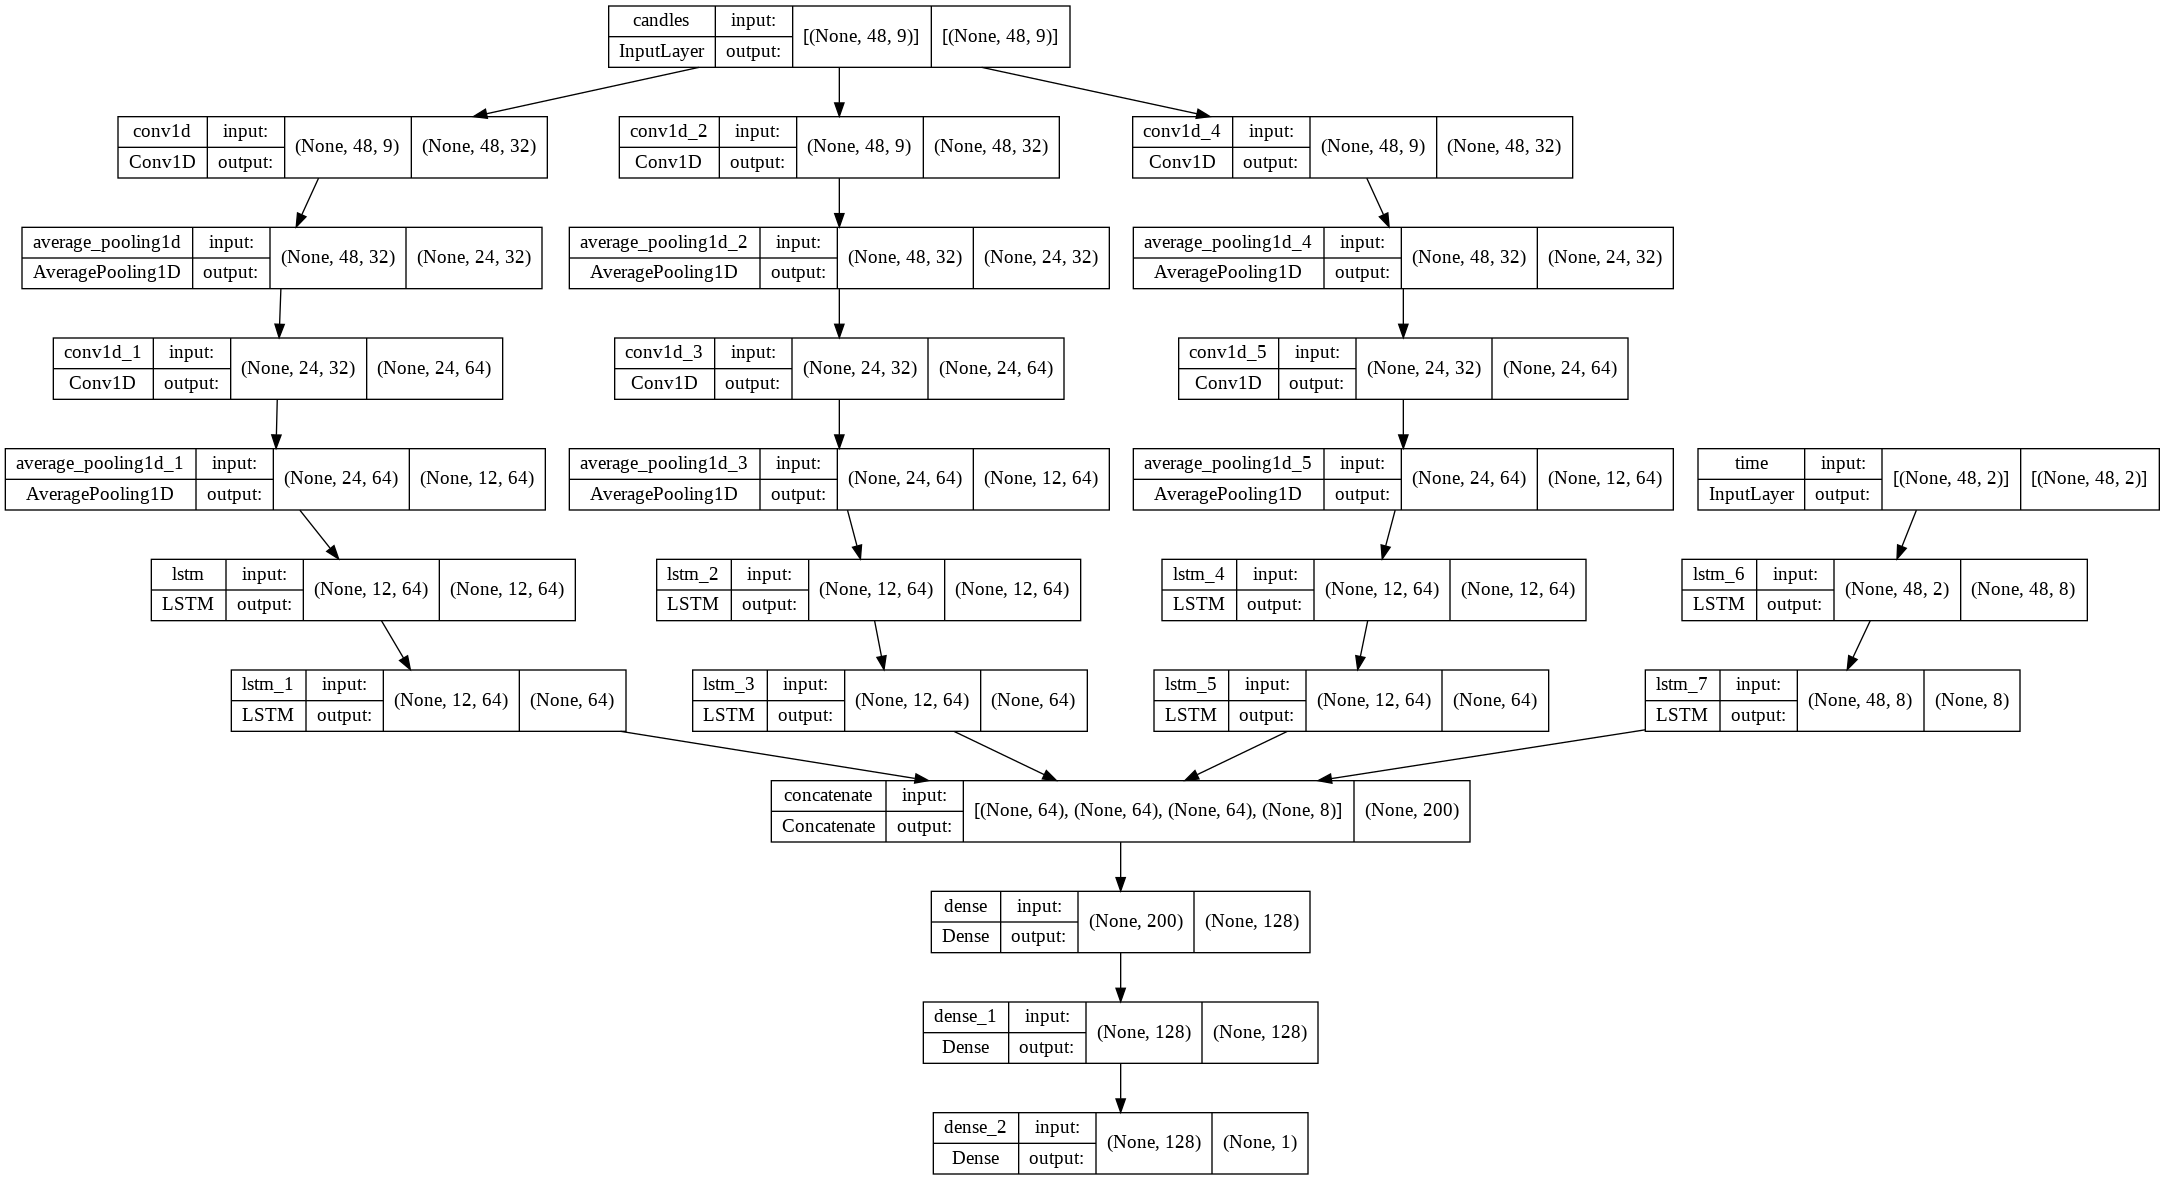

In [18]:
keras.utils.plot_model(btc_model.model, "conv_lstm_net.png", show_shapes=True)

In [19]:
model_name = "model/LSTM_CNN_model"
btc_model.sats2train(model_name)

Epoch 1/20
11/11 [==============================] - 26s 461ms/step - loss: 0.2050 - val_loss: 0.1453
Epoch 2/20
11/11 [==============================] - 1s 97ms/step - loss: 0.0550 - val_loss: 0.0752
Epoch 3/20
11/11 [==============================] - 1s 96ms/step - loss: 0.0375 - val_loss: 0.0677
Epoch 4/20
11/11 [==============================] - 1s 98ms/step - loss: 0.0199 - val_loss: 0.0065
Epoch 5/20
11/11 [==============================] - 1s 86ms/step - loss: 0.0267 - val_loss: 0.0099
Epoch 6/20
11/11 [==============================] - 1s 86ms/step - loss: 0.0242 - val_loss: 0.0202
Epoch 7/20
11/11 [==============================] - 1s 86ms/step - loss: 0.0430 - val_loss: 0.0573
Epoch 8/20
11/11 [==============================] - 1s 86ms/step - loss: 0.0286 - val_loss: 0.0471
Epoch 9/20
11/11 [==============================] - 1s 95ms/step - loss: 0.0179 - val_loss: 0.0144
Epoch 10/20
11/11 [==============================] - 1s 86ms/step - loss: 0.0189 - val_loss: 0.0303
Epoch 1

INFO:tensorflow:Assets written to: model/LSTM_CNN_model/assets


INFO:tensorflow:Assets written to: model/LSTM_CNN_model/assets


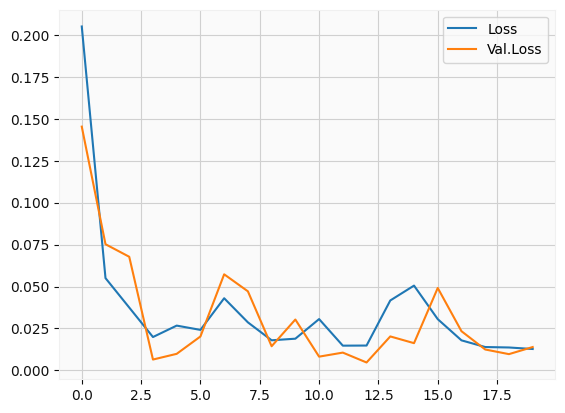

In [20]:
plt.plot(btc_model.history.history['loss'], label='Loss')
plt.plot(btc_model.history.history['val_loss'], label='Val.Loss')
plt.legend(loc="upper right")
plt.show()

In [21]:
btc_model.sats2pred(predict_on_test = True)

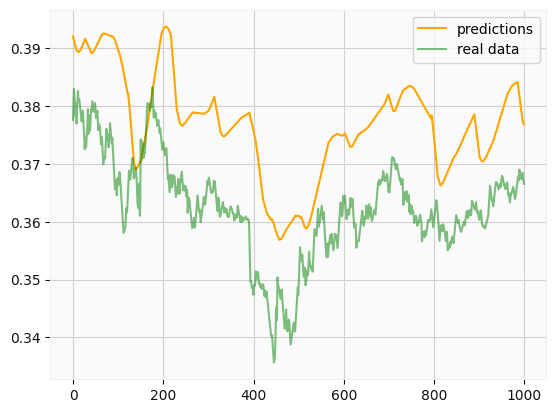

In [22]:
plt.plot(btc_model.preds[-1000:], color='orange', label='predictions')
plt.plot(btc_model.y_test[-1000:], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

In [28]:
true_vals = c2t.denorm(ts_btc.scaler, ts_btc.candles, ts_btc.candles_norm[:,-1])
preds = c2t.denorm(ts_btc.scaler, ts_btc.candles, btc_model.preds)

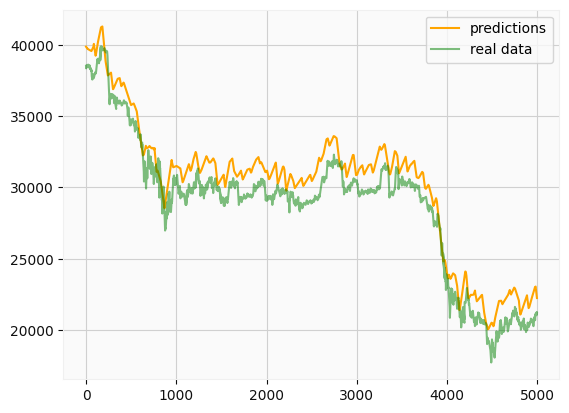

In [29]:
plt.plot(preds[0:len(ts_btc.x_candles)-btc_model.split_point], color='orange', label='predictions')
plt.plot(true_vals[btc_model.split_point:len(ts_btc.x_candles)], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

## Rough back-testing buy or do nothing, i.e. up-only

Fee: 0.025
----------------------
Buy      4175 ( 2139 ok 2036 ko )
No-op    821
Wallet   7090.654749999992
Drawback -1549.9947499999987
Total earned 7090.654749999992


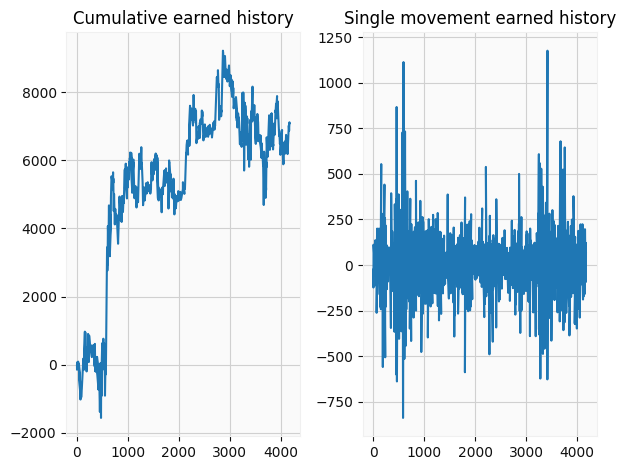

In [30]:

total_wallet_history, single_wallet_history, wallet = ts_btc.backtest(preds, true_vals, btc_model.split_point, ts_btc.step_back, fee=0.025)

print('Total earned', wallet)

plt.subplot(1, 2, 1)
plt.plot(total_wallet_history)
plt.title('Cumulative earned history')

plt.subplot(1, 2, 2)
plt.plot(single_wallet_history)
plt.title('Single movement earned history')

plt.tight_layout()
plt.show()

## Train for more epochs

In [31]:
preds_old = btc_model.preds
y_test_old = btc_model.y_test

In [32]:
btc_model.sats2train(model_name, epochs = 100)

Epoch 1/100
11/11 [==============================] - 1s 102ms/step - loss: 0.0120 - val_loss: 0.0148
Epoch 2/100
11/11 [==============================] - 1s 86ms/step - loss: 0.0123 - val_loss: 0.0055
Epoch 3/100
11/11 [==============================] - 1s 87ms/step - loss: 0.0122 - val_loss: 0.0061
Epoch 4/100
11/11 [==============================] - 1s 86ms/step - loss: 0.0120 - val_loss: 0.0117
Epoch 5/100
11/11 [==============================] - 1s 96ms/step - loss: 0.0119 - val_loss: 0.0128
Epoch 6/100
11/11 [==============================] - 1s 96ms/step - loss: 0.0118 - val_loss: 0.0045
Epoch 7/100
11/11 [==============================] - 1s 99ms/step - loss: 0.0117 - val_loss: 0.0063
Epoch 8/100
11/11 [==============================] - 1s 87ms/step - loss: 0.0117 - val_loss: 0.0116
Epoch 9/100
11/11 [==============================] - 1s 96ms/step - loss: 0.0115 - val_loss: 0.0125
Epoch 10/100
11/11 [==============================] - 1s 97ms/step - loss: 0.0115 - val_loss: 0.005

INFO:tensorflow:Assets written to: model/LSTM_CNN_model/assets


INFO:tensorflow:Assets written to: model/LSTM_CNN_model/assets


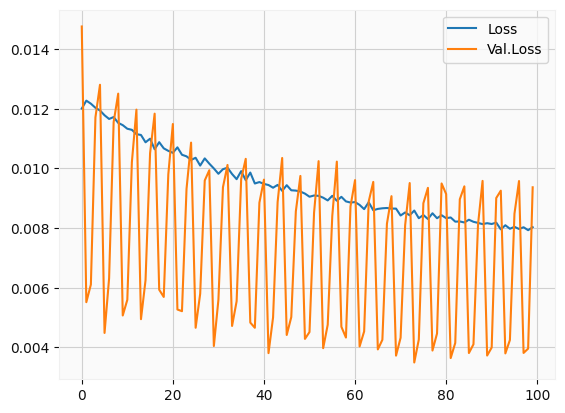

In [33]:
plt.plot(btc_model.history.history['loss'], label='Loss')
plt.plot(btc_model.history.history['val_loss'], label='Val.Loss')
plt.legend(loc="upper right")
plt.show()

In [34]:
btc_model.sats2pred(predict_on_test = True)

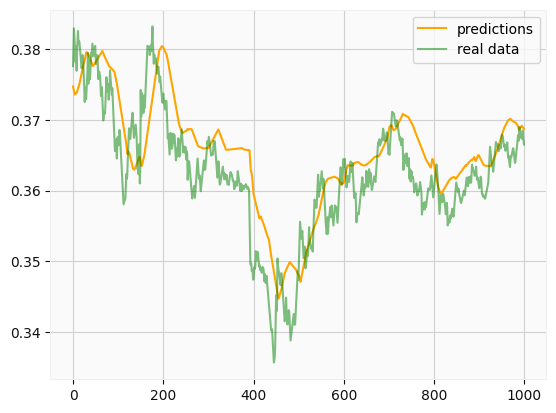

In [35]:
plt.plot(btc_model.preds[-1000:], color='orange', label='predictions')
plt.plot(btc_model.y_test[-1000:], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

In [36]:
true_vals = c2t.denorm(ts_btc.scaler, ts_btc.candles, ts_btc.candles_norm[:,-1])
preds = c2t.denorm(ts_btc.scaler, ts_btc.candles, btc_model.preds)

Fee: 0.025
----------------------
Buy      399 ( 233 ok 166 ko )
No-op    4597
Wallet   12587.914999999963
Drawback -927.1227499999984
Total earned 12587.914999999963


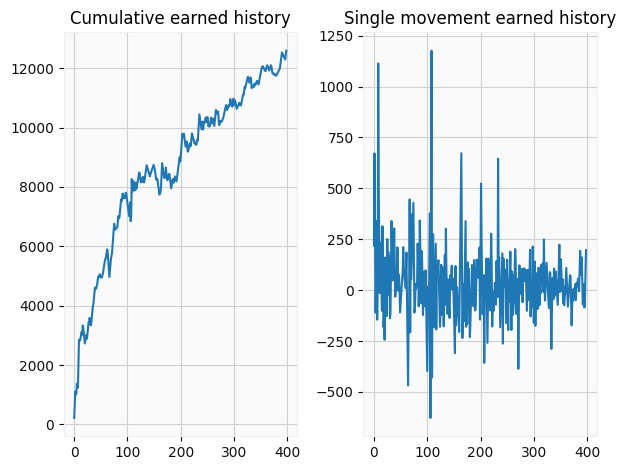

In [37]:

total_wallet_history, single_wallet_history, wallet = ts_btc.backtest(preds, true_vals, btc_model.split_point, ts_btc.step_back, fee=0.025)
print('Total earned', wallet)

plt.subplot(1, 2, 1)
plt.plot(total_wallet_history)
plt.title('Cumulative earned history')

plt.subplot(1, 2, 2)
plt.plot(single_wallet_history)
plt.title('Single movement earned history')

plt.tight_layout()
plt.show()

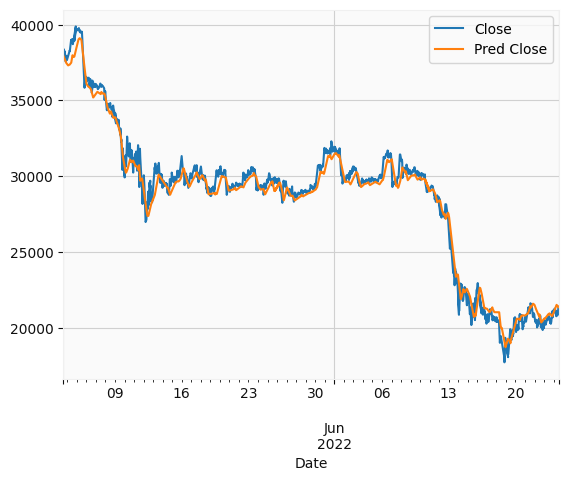

In [39]:
import src.timeutils as tu
shifted_time_indexes = tu.shift_time_index(can_btc.candles.index,1,can_btc.dtime_index)
series_predicted = tu.arr2series(preds,"Pred Close",shifted_time_indexes,top_or_bottom="bottom")
df_preds_true = tu.mergetimeseries(can_btc.candles["Close"], series_predicted)
df_preds_true.dropna().plot()

In [40]:

df_pred_exp = pd.DataFrame(np.array([preds,true_vals[-len(preds):]]).T,columns=["Predicted","Expected"])

df_pred_exp["Return Expected"] = tu.log_return(df_pred_exp["Expected"],periods=-1)
df_pred_exp["Return Predicted"] = tu.log_return(df_pred_exp["Predicted"],periods=-1)


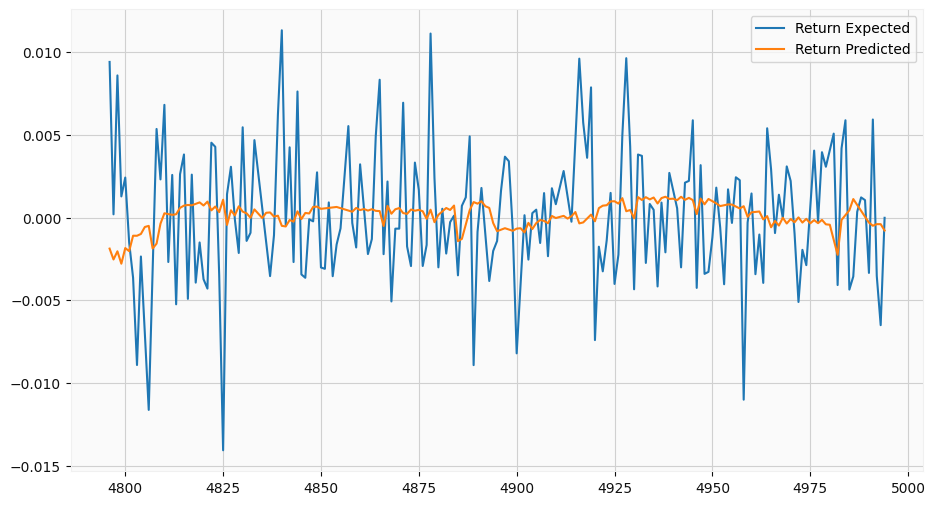

In [41]:
f, axs = plt.subplots( figsize=(11, 6))
df_pred_exp.iloc[-200:].plot(y="Return Expected",ax=axs)
df_pred_exp.iloc[-200:].plot(y="Return Predicted",ax=axs)